In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
df = pd.read_csv('training_data.csv')

Let's print the autocorrelation for the time series lags:

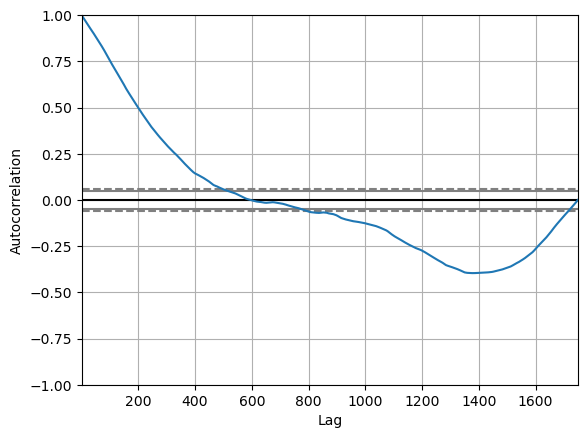

In [3]:
autocorrelation_plot(df['Close'])
plt.show()

We can see there is a positive correlation with the first 100 lags that is about 14 days (or 3 weeks). It may be beneficial to train with daily data or even weekly data to minimise the training cost. Depending on the period of prediction we are going to make, we initiate the model with the most significant lags.

In [4]:
# Split the data into training and test sets
train, test = train_test_split(df, train_size=0.9)

In [5]:
# Fit auto_arima
model = pm.auto_arima(train['Close'], max_p=14, max_d=2, max_q=5, trace=True, error_action='ignore', suppress_warnings=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-11688.466, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11694.112, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11693.260, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11693.212, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11689.752, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-11692.610, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.232 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1574
Model:               SARIMAX(0, 1, 0)   Log Likelihood                5849.056
Date:                Wed, 24 Apr 2024   AIC                         -11694.112
Time:                        18:08:55   BIC                         -11683.390
Sample:                             0   HQIC                        -11690.12

We make the prediction and calculate the Root Mean Square Error:

In [6]:
# Make predictions
forecast, conf_int = model.predict(n_periods=len(test['Close']), return_conf_int=True)

for idx in forecast.index:
    yhat = forecast.loc[idx]
    obs = test['Close'].loc[idx]
    print(f'predicted={yhat}, expected={obs}')

rmse = sqrt(mean_squared_error(test['Close'], forecast))
print('Test RMSE: %.3f' % rmse)

predicted=5.700181659570472, expected=5.699138325107128
predicted=5.700555407410583, expected=5.703282369969748
predicted=5.700929155250694, expected=5.707525460935035
predicted=5.701302903090806, expected=5.710758108596253
predicted=5.701676650930917, expected=5.711122515610192
predicted=5.7020503987710285, expected=5.710989817343234
predicted=5.70242414661114, expected=5.713732805509369
predicted=5.702797894451251, expected=5.723024458582486
predicted=5.7031716422913625, expected=5.72580483480841
predicted=5.703545390131474, expected=5.723013082848065
predicted=5.703919137971585, expected=5.727010561019566
predicted=5.704292885811697, expected=5.730180928695731
predicted=5.704666633651808, expected=5.736894845788814
predicted=5.705040381491919, expected=5.735765520509252
predicted=5.705414129332031, expected=5.749106332285976
predicted=5.705787877172142, expected=5.751015903187666
predicted=5.706161625012253, expected=5.750411598551994
predicted=5.706535372852365, expected=5.74923377

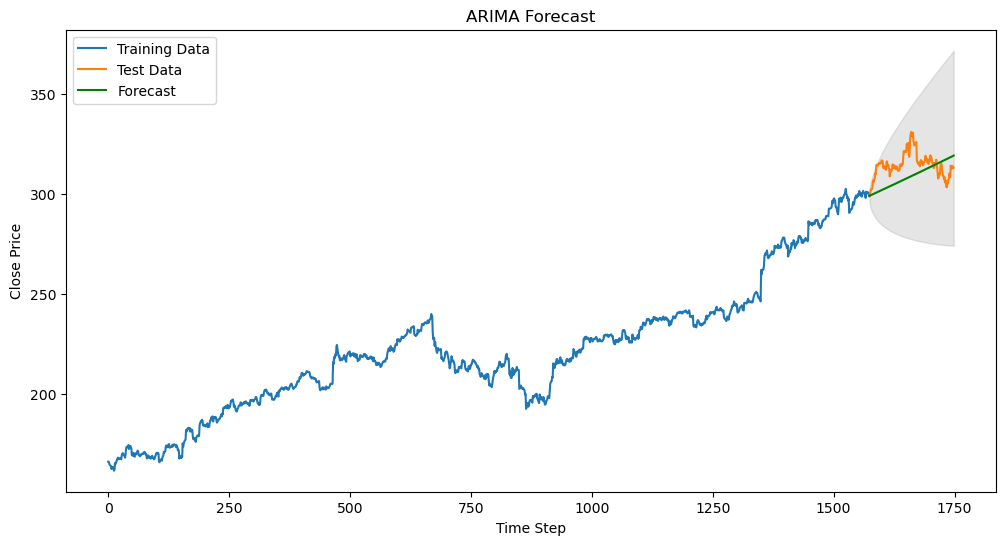

In [7]:
# Plot the results
x_axis = np.arange(train.shape[0] + test.shape[0])

plt.figure(figsize=(12, 6))
plt.plot(x_axis[:train.shape[0]], np.exp(train['Close']), label='Training Data')
plt.plot(x_axis[train.shape[0]:], np.exp(test['Close']), label='Test Data')
plt.plot(x_axis[train.shape[0]:], np.exp(forecast), label='Forecast', color='green')
plt.fill_between(x_axis[train.shape[0]:], np.exp(conf_int[:, 0]), np.exp(conf_int[:, 1]), color='gray', alpha=0.2)
plt.title('ARIMA Forecast')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend(loc='upper left')
plt.show()

From the above graph, we can see the test set falls inside the area of the prediction model with 95% confidence.

In [8]:
model2 = pm.auto_arima(df['Close'], max_p=14, max_d=2, max_q=5, trace=True, error_action='ignore', suppress_warnings=True)
# Make predictions for the next 10 days
forecast_next_10_days, conf_int_next_10_days = model2.predict(n_periods=70, return_conf_int=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-13002.892, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13009.259, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13007.966, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-13007.942, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13004.551, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13006.964, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.412 seconds


In [9]:
x_axis = np.arange(df.shape[0] + forecast_next_10_days.shape[0])
x_axis

array([   0,    1,    2, ..., 1816, 1817, 1818])

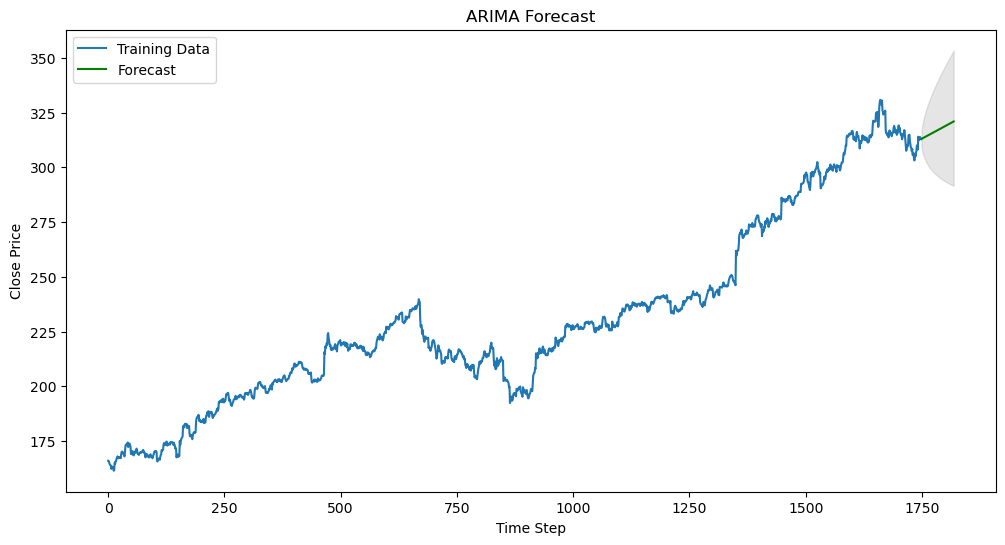

In [10]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(x_axis[:df.shape[0]], np.exp(df['Close']), label='Training Data')
plt.plot(x_axis[df.shape[0]:], np.exp(forecast_next_10_days), label='Forecast', color='green')
plt.fill_between(x_axis[df.shape[0]:], np.exp(conf_int_next_10_days[:, 0]), np.exp(conf_int_next_10_days[:, 1]), color='gray', alpha=0.2)
plt.title('ARIMA Forecast')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend(loc='upper left')
plt.show()

Finally, I want to see the range of price of Tesla it may have to see if it worths investing in.

In [11]:
print('lowest' + str(np.exp(conf_int_next_10_days[69:, 0])) + ' highest' + str(np.exp(conf_int_next_10_days[69:, 1])))

lowest[291.58790867] highest[353.26196548]
